In [1]:
# %%

%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs

import numpy as np
import torch
import plotly.express as px


from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


In [2]:
import pathlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

persister = HackyPersister(dir_path=pathlib.Path("./models/mess3"))
model = persister.load_final_model()
train_config = persister.load_training_config()

Checkpoints found: 31785
Last checkpoint: 509376000.pt
seed: 42
n_ctx: 10
act_fn: relu
d_head: 16
d_model: 128
d_vocab: 2
n_heads: 4
n_iters: 25
n_layers: 4
attn_only: False
optimizer: sgd
batch_size: 64
num_epochs: 150000000
init_weights: True
weight_decay: 0
attention_dir: causal
learning_rate: 0.01
use_attn_scale: True
normalization_type: LN


In [3]:

process = RRXOR()
mixed_state_tree = process.derive_mixed_state_presentation(depth=train_config["n_ctx"] + 1)
# in order to plot the belief states in the simplex, we need to get the paths and beliefs from the MSP
tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

# lets print out the first few paths and beliefs
for path, belief in zip(tree_paths[:5], tree_beliefs[:5]):
    print(f"Path: {''.join([str(x) for x in path])}, Belief: {belief}")

# the MSP states are the unique beliefs in the tree
msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
print(f"Number of Unique beliefs: {len(set(msp_beliefs))} out of {len(msp_beliefs)}")

# now lets index each belief
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

for i in range(5):
    ith_belief = list(msp_belief_index.keys())[i]
    print(f"{ith_belief} is indexed as {msp_belief_index[ith_belief]}")

Path: 11010100010, Belief: [0. 0. 0. 1. 0.]
Path: 1100001100, Belief: [0.         0.66666667 0.         0.         0.33333333]
Path: 1010101110, Belief: [0. 0. 0. 1. 0.]
Path: 0001010000, Belief: [0. 1. 0. 0. 0.]
Path: 10101110100, Belief: [0. 0. 0. 0. 1.]
Number of Unique beliefs: 36 out of 1723
(0.5, 0.25, 0.0, 0.0, 0.25) is indexed as 0
(0.33333, 0.0, 0.33333, 0.16667, 0.16667) is indexed as 1
(0.0, 0.66667, 0.0, 0.0, 0.33333) is indexed as 2
(0.0, 0.0, 1.0, 0.0, 0.0) is indexed as 3
(0.0, 0.0, 0.5, 0.5, 0.0) is indexed as 4


In [4]:

def run_visualization_pca(beliefs):
    pca = PCA(n_components=3)
    pca.fit(beliefs)

    return pca

def visualize_ground_truth_simplex_3d(beliefs, belief_labels, pca):

    beliefs_pca = pca.transform(beliefs)

    colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24 + px.colors.qualitative.Plotly
    fig = px.scatter_3d(beliefs_pca, x=0, y=1, z=2,
                        color=[str(i) for i in belief_labels],
                        color_discrete_sequence=colors)
    fig.show()

vis_pca = run_visualization_pca(list(msp_belief_index.keys()))
index = list(msp_belief_index.values())
visualize_ground_truth_simplex_3d(list(msp_belief_index.keys()),
                                  list(msp_belief_index.values()),
                                  vis_pca)

# now lets set up all the inputs as they arrive into the transformer
device = 'cpu'
transformer_inputs = [x for x in tree_paths if len(x) == train_config["n_ctx"]]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

# print first few batches
print(transformer_inputs[:5])

transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs, msp_belief_index, tree_paths, tree_beliefs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = persister.load_model(ckpt_num=persister.get_model_checkpoints()[-1], device='cpu')

_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)

print(activations.keys())


# we now have activations [batch, n_ctx, d_model]
# and we have transformer_input_beliefs [batch, n_ctx, belief_dim]
# and we have transformer_input_belief_indices [batch, n_ctx]

# in the end we want to do linear regression between the activations and the transformer_input_beliefs
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]
    
    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions

#acts = torch.concatenate((activations["blocks.0.ln1.hook_normalized"], activations["blocks.1.ln1.hook_normalized"], activations["blocks.2.ln1.hook_normalized"], activations["blocks.3.ln1.hook_normalized"]), dim=-1)
#acts = activations["blocks.3.hook_resid_post"]
# torch concat everything in activations
acts = torch.concatenate(list(activations.values()), dim=-1)
print(acts.shape)
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
print(belief_predictions.shape)


belief_predictions_pca = vis_pca.transform(belief_predictions.reshape(-1, 5))

tensor([[1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 1, 0, 1, 1, 0],
        [1, 0, 1, 0, 0, 0, 1, 0, 1, 0]], dtype=torch.int32)
dict_keys(['blocks.0.hook_resid_pre', 'blocks.0.hook_resid_mid', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.hook_resid_mid', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'blocks.2.hook_resid_mid', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_pre', 'blocks.3.hook_resid_mid', 'blocks.3.hook_resid_post'])
torch.Size([436, 10, 1536])
(436, 10, 5)


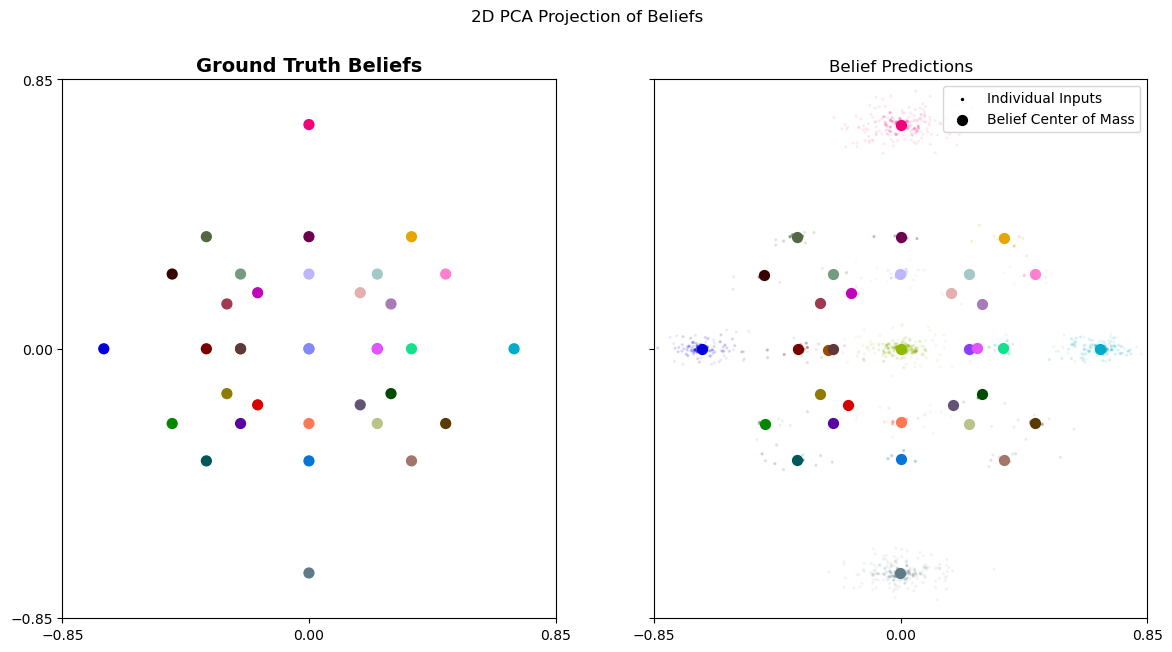

In [5]:


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import colorcet as cc

colors = cc.glasbey_bw_minc_20_maxl_70

# Flatten the belief indices
transformer_input_belief_indices_flattened = transformer_input_belief_indices.view(-1).cpu().numpy()

# Function to run PCA
def run_visualization_pca(beliefs):
    pca = PCA(n_components=3)  # Change to 2 components for 2D visualization
    pca.fit(beliefs)
    return pca

# Function to visualize beliefs in 2D
def visualize_ground_truth_simplex_2d(ax, beliefs, belief_labels, pca, colors):
    beliefs_pca = pca.transform(beliefs)
    scatter = ax.scatter(beliefs_pca[:, 0], beliefs_pca[:, 2], 
                          facecolors=[colors[label] for label in belief_labels], alpha=1.0, s=50)
    return scatter

# Run PCA
vis_pca = run_visualization_pca(list(msp_belief_index.keys()))
index = list(msp_belief_index.values())

# Create figure and subplots with shared x and y axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

# Visualize ground truth beliefs
scatter1 = visualize_ground_truth_simplex_2d(ax1, list(msp_belief_index.keys()), list(msp_belief_index.values()), vis_pca, colors)

# Visualize belief predictions
for belief in msp_belief_index.keys():
    b = msp_belief_index[belief]
    relevant_indices = np.where(transformer_input_belief_indices_flattened == b)[0]
    relevant_data = belief_predictions_pca[relevant_indices]
    if len(relevant_data) > 0:
        centers_of_mass = np.mean(relevant_data, axis=0)
        scatter_individuals = ax2.scatter(relevant_data[:, 0], relevant_data[:, 2], 
                                          c=[colors[b]] * len(relevant_data), s=2, alpha=0.05)
        scatter_centers = ax2.scatter(centers_of_mass[0], centers_of_mass[2], 
                                      c=[colors[b]], s=50, alpha=1)

# Add legend for "Individual Inputs" and "Belief Center of Mass"
scatter_individuals = ax2.scatter([], [], c='black', s=2, alpha=1, label='Individual Inputs')
scatter_centers = ax2.scatter([], [], c='black', s=50, alpha=1, label='Belief Center of Mass')
ax2.legend()

#visualize_ground_truth_simplex_2d(ax2, list(msp_belief_index.keys()), list(msp_belief_index.values()), vis_pca, colors)

# Set limits for both plots
limits = {
    'x': [-.85, .85],
    'y': [-.85, .85]
}

ax1.set_xlim(limits['x'])
ax1.set_ylim(limits['y'])
ax2.set_xlim(limits['x'])
ax2.set_ylim(limits['y'])

# Set grid lines at 0, -.6, and .6
# Comment out the grid lines setting for both plots
ax1.xaxis.set_major_locator(plt.FixedLocator([-.85, 0, .85]))
ax1.yaxis.set_major_locator(plt.FixedLocator([-.85, 0, .85]))
ax2.xaxis.set_major_locator(plt.FixedLocator([-.85, 0, .85]))
ax2.yaxis.set_major_locator(plt.FixedLocator([-.85, 0, .85]))
ax1.set_title('Ground Truth Beliefs', fontsize=14, fontweight='bold')

ax2.set_title('Belief Predictions')

plt.suptitle('2D PCA Projection of Beliefs')
plt.show()

In [6]:
T = RRXOR().transition_matrix
msp_belief_token_prediction = {}
for b, i in msp_belief_index.items():
    b_numpy = np.array(b)
    optimal_output = np.einsum('esd,s->e', T, b_numpy)
    msp_belief_token_prediction[b] = optimal_output



def string_key(values, precision=5):
    return tuple(f"{round(value, precision):.{precision}f}" for value in values)

def create_string_key(values, precision=5):
    return tuple(f"{round(value, precision):.{precision}f}" for value in values)

# Example of setting up the dictionary with string keys
msp_belief_token_prediction_str = {}
# Populate the dictionary, assuming 'some_belief_array' and 'prediction' are your data sources
for belief, prediction in msp_belief_token_prediction.items():
    key = create_string_key(belief)
    msp_belief_token_prediction_str[key] = prediction


n_batch, n_ctx = transformer_inputs.shape
for b in range(n_batch):
    for c in range(n_ctx):
        input = transformer_inputs[b, :c]
        belief = transformer_input_beliefs[b, c, :]
        belief_set = string_key(belief.cpu().numpy())
        
        next_token_prediction = msp_belief_token_prediction_str.get(belief_set)
        if next_token_prediction is not None:
            print(f"Input: {input}, Belief: {belief}, Next Token Prediction: {next_token_prediction}")
        else:
            print("No prediction found for this belief set.")

import pandas as pd
# for every input we need
# 1) DONE activations  # [batch, n_ctx, d_model]
# 2) belief representation (this is the projection of the activations)
# 3) next token prediction
# 4) ground truth belief
print(acts.shape)
print(belief_predictions.shape)

print(transformer_input_beliefs.shape)
df = pd.DataFrame(columns=["Input", "Ground Truth Belief", "Ground Truth Next Token Prediction", "Transformer Belief"])
for b in range(n_batch):
    for c in range(n_ctx):
        input = transformer_inputs[b, :c]
        input_str = ''.join([str(int(x)) for x in input.cpu().numpy()])
        activation = acts[b, c, :]
        ground_truth_belief = transformer_input_beliefs[b, c, :].cpu().numpy()
        ground_truth_next_token_prediction = msp_belief_token_prediction_str.get(string_key(ground_truth_belief))
        transformer_belief = belief_predictions[b, c, :]

        # put this all into a pandas dataframe
        new_row = {"Input": input_str,
                   "Ground Truth Belief": ground_truth_belief,
                   "Ground Truth Next Token Prediction": ground_truth_next_token_prediction,
                   "Transformer Belief": transformer_belief,
                   "Activation": activation.cpu().numpy()}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

# go row by row and compute the L2 distance between the ground truth belief and the transformer belief
for i in range(len(df)):
    df.loc[i, 'Error'] = np.mean((df.loc[i, 'Ground Truth Belief'] - df.loc[i, 'Transformer Belief']) ** 2)


Input: tensor([], dtype=torch.int32), Belief: tensor([0.3333, 0.0000, 0.3333, 0.1667, 0.1667]), Next Token Prediction: [0.5 0.5]
Input: tensor([1], dtype=torch.int32), Belief: tensor([0.3333, 0.0000, 0.3333, 0.0000, 0.3333]), Next Token Prediction: [0.66666 0.33333]
Input: tensor([1, 1], dtype=torch.int32), Belief: tensor([0.5000, 0.2500, 0.0000, 0.2500, 0.0000]), Next Token Prediction: [0.375 0.625]
Input: tensor([1, 1, 0], dtype=torch.int32), Belief: tensor([0.0000, 0.6667, 0.0000, 0.0000, 0.3333]), Next Token Prediction: [0.666665 0.333335]
Input: tensor([1, 1, 0, 0], dtype=torch.int32), Belief: tensor([0.5000, 0.0000, 0.0000, 0.0000, 0.5000]), Next Token Prediction: [0.75 0.25]
Input: tensor([1, 1, 0, 0, 0], dtype=torch.int32), Belief: tensor([0.6667, 0.3333, 0.0000, 0.0000, 0.0000]), Next Token Prediction: [0.5 0.5]
Input: tensor([1, 1, 0, 0, 0, 0], dtype=torch.int32), Belief: tensor([0.0000, 0.0000, 0.6667, 0.3333, 0.0000]), Next Token Prediction: [0.333335 0.666665]
Input: tenso

In [7]:
# %%
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist


# Assuming df is your existing DataFrame and is populated
n_rows = len(df)  # Ensure we have the correct number of rows

# Function to convert data for distance calculation
def prepare_data(column):
    return np.stack(df[column].apply(np.array))

# Prepare data arrays
ground_truth_beliefs = prepare_data('Ground Truth Belief')
next_token_predictions = prepare_data('Ground Truth Next Token Prediction')
transformer_beliefs = prepare_data('Transformer Belief')
activations = prepare_data('Activation')

# Compute pairwise distances using cdist
gt_belief_distances = cdist(ground_truth_beliefs, ground_truth_beliefs, metric='euclidean')
next_token_pred_distances = cdist(next_token_predictions, next_token_predictions, metric='euclidean')
transformer_belief_distances = cdist(transformer_beliefs, transformer_beliefs, metric='euclidean')
activation_distances = cdist(activations, activations, metric='euclidean')

# Generate Input Pairs correctly matching the shape of upper triangular matrix without diagonal
#input_pairs = [f"{df.iloc[i]['Input']} - {df.iloc[j]['Input']}" for i in range(n_rows) for j in range(i + 1, n_rows)]

# Create DataFrame from distances
distance_data = {
    #"Input Pair": input_pairs,
    "Ground Truth Belief Distance": gt_belief_distances[np.triu_indices(n_rows, k=1)],
    "Ground Truth Next Token Prediction Distance": next_token_pred_distances[np.triu_indices(n_rows, k=1)],
    "Transformer Belief Distance": transformer_belief_distances[np.triu_indices(n_rows, k=1)],
    "Activation Distance": activation_distances[np.triu_indices(n_rows, k=1)]
}

distance_df = pd.DataFrame(distance_data)

# Print shapes to verify correctness
for i, v in distance_data.items():
    print(i, v.shape)  # All should match now


Ground Truth Belief Distance (9502620,)
Ground Truth Next Token Prediction Distance (9502620,)
Transformer Belief Distance (9502620,)
Activation Distance (9502620,)


In [8]:
# %%
_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x or 'ln_final.hook_normalized' in x)

relevant_activation_keys = ['blocks.0.hook_resid_pre', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post', 'ln_final.hook_normalized']
keys_legend_names = ['0', '1', '2', '3', '4', 'ln_final']
key_legend_dict = {k: keys_legend_names[i] for i, k in enumerate(relevant_activation_keys)}
#only keep the relevant activations
activations = {k: activations[k] for k in relevant_activation_keys}
num_acts = len(activations)
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
set_inds = set(range(num_acts))


activations

{'blocks.0.hook_resid_pre': tensor([[[ 0.1089,  0.2040, -0.2741,  ...,  0.1497, -0.0144,  0.0097],
          [ 0.2769,  0.1128, -0.1431,  ...,  0.0955,  0.0569,  0.0974],
          [-0.0436,  0.0566,  0.0571,  ...,  0.1405,  0.0476,  0.1014],
          ...,
          [-0.0445,  0.0939, -0.0396,  ...,  0.0338, -0.0034, -0.0358],
          [ 0.1286,  0.0896,  0.2046,  ...,  0.0786,  0.0973,  0.0708],
          [ 0.1283, -0.0265, -0.0069,  ..., -0.0213,  0.1010,  0.1191]],
 
         [[ 0.1089,  0.2040, -0.2741,  ...,  0.1497, -0.0144,  0.0097],
          [ 0.2461,  0.0662,  0.0572,  ...,  0.0160,  0.0381,  0.0395],
          [-0.0128,  0.1032, -0.1432,  ...,  0.2200,  0.0664,  0.1593],
          ...,
          [-0.0445,  0.0939, -0.0396,  ...,  0.0338, -0.0034, -0.0358],
          [ 0.1595,  0.1362,  0.0043,  ...,  0.1581,  0.1161,  0.1287],
          [ 0.1283, -0.0265, -0.0069,  ..., -0.0213,  0.1010,  0.1191]],
 
         [[ 0.0781,  0.1574, -0.0738,  ...,  0.0702, -0.0332, -0.0482],
 

In [9]:
from tqdm import tqdm
import seaborn as sns
# import pallete

results_df = pd.DataFrame(columns=["Input", "Ground Truth Belief", "Ground Truth Next Token Prediction", "Transformer Belief", 'Error', 'activation_type'])
for acts_ in tqdm(activations):
    acts = activations[acts_]
    regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)


    df = pd.DataFrame(columns=["Input", "Ground Truth Belief", "Ground Truth Next Token Prediction", "Transformer Belief", "activation_type"])
    for b in range(n_batch):
        for c in range(n_ctx):
            input = transformer_inputs[b, :c]
            input_str = ''.join([str(int(x)) for x in input.cpu().numpy()])
            activation = acts[b, c, :]
            ground_truth_belief = transformer_input_beliefs[b, c, :].cpu().numpy()
            ground_truth_next_token_prediction = msp_belief_token_prediction_str.get(string_key(ground_truth_belief))
            transformer_belief = belief_predictions[b, c, :]



            # put this all into a pandas dataframe
            new_row = {"Input": input_str,
                    "Ground Truth Belief": ground_truth_belief,
                    "Ground Truth Next Token Prediction": ground_truth_next_token_prediction,
                    "Transformer Belief": transformer_belief,
                    "Activation": activation.cpu().numpy()}
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # go row by row and compute the L2 distance between the ground truth belief and the transformer belief
    for i in range(len(df)):
        df.loc[i, 'Error'] = np.mean((df.loc[i, 'Ground Truth Belief'] - df.loc[i, 'Transformer Belief']) ** 2)
    df['activation_type'] = key_legend_dict[acts_]

    # add the results to the results_df
    results_df = pd.concat([results_df, df], ignore_index=True)

#make acts concat
acts = torch.concatenate(list(activations.values()), dim=-1)
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)


df = pd.DataFrame(columns=["Input", "Ground Truth Belief", "Ground Truth Next Token Prediction", "Transformer Belief"])
for b in range(n_batch):
    for c in range(n_ctx):
        input = transformer_inputs[b, :c]
        input_str = ''.join([str(int(x)) for x in input.cpu().numpy()])
        activation = acts[b, c, :]
        ground_truth_belief = transformer_input_beliefs[b, c, :].cpu().numpy()
        ground_truth_next_token_prediction = msp_belief_token_prediction_str.get(string_key(ground_truth_belief))
        transformer_belief = belief_predictions[b, c, :]



        # put this all into a pandas dataframe
        new_row = {"Input": input_str,
                "Ground Truth Belief": ground_truth_belief,
                "Ground Truth Next Token Prediction": ground_truth_next_token_prediction,
                "Transformer Belief": transformer_belief,
                "Activation": activation.cpu().numpy()}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

# go row by row and compute the L2 distance between the ground truth belief and the transformer belief
for i in range(len(df)):
    df.loc[i, 'Error'] = np.mean((df.loc[i, 'Ground Truth Belief'] - df.loc[i, 'Transformer Belief']) ** 2)

df['activation_type'] = 'concat'

# add the results to the results_df
results_df = pd.concat([results_df, df], ignore_index=True)


  0%|          | 0/6 [00:00<?, ?it/s]/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_15355/2586292582.py:37: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

100%|██████████| 6/6 [00:27<00:00,  4.55s/it]


(0.0, 1.4142135623730951)
(0.0, 2.0514884546674006)
(0.0, 1.4142135623730951)
(0.0, 2.0514884546674006)
(-0.30000000000000004, 6.3)
(-0.01, 0.07439032688382367)


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_15355/1052296884.py:164: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



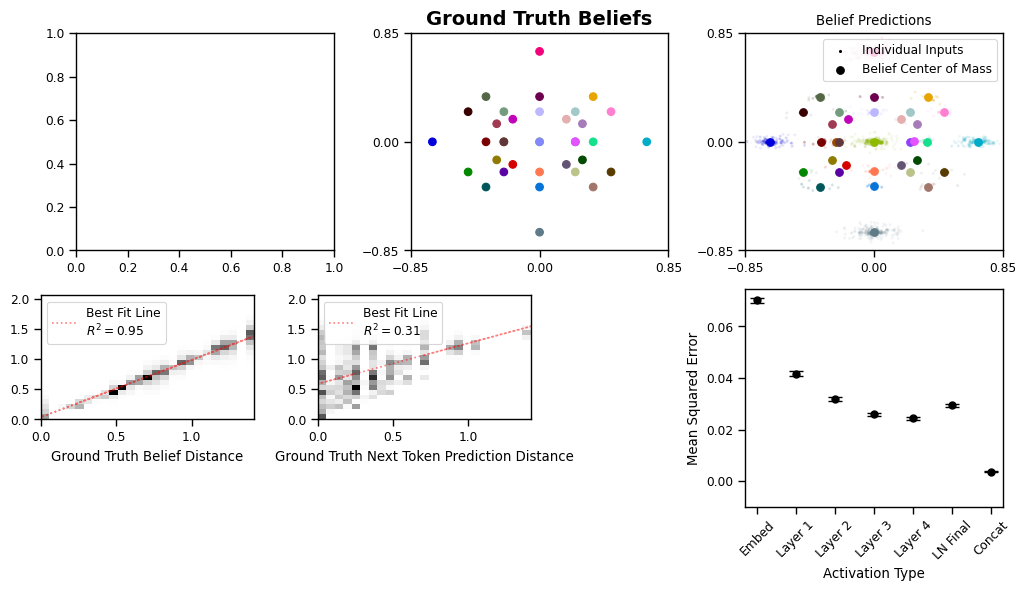

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#palette = sns.color_palette("viridis", n_colors=len(mean_errors)-1)[::-1] + ["black"]
sns.set_context("paper")


# make a fig that is 2x 3
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Share y-axis only for axs[1, 0] and axs[1, 1]
axs[1, 1].sharey(axs[1, 0])

dims = 4
largest_distance = np.max(distance_df['Ground Truth Belief Distance'])

# Setting up the figure and axes

# Define the pairs of columns to plot
columns_pairs = [
    ('Ground Truth Belief Distance', 'Transformer Belief Distance'),
    ('Ground Truth Next Token Prediction Distance', 'Transformer Belief Distance'),
    #('Ground Truth Belief Distance', 'Activation Distance'),
    #('Ground Truth Next Token Prediction Distance', 'Activation Distance')
]

# Create a 2x2 grid of axes within the existing figure
axs[1, 0].remove()
axs[1, 1].remove()
inner_grid = fig.add_gridspec(2, 2,  left=0.01, right=.5, top=0.5, bottom=0.05)
# Iterate over each subplot and pair of columns for the top row of the new 2x2 grid
for i, (x_col, y_col) in enumerate(columns_pairs):
    ax = fig.add_subplot(inner_grid[i // 2, i % 2])
    ax = fig.add_subplot(ax)

    x = distance_df[x_col]
    y = distance_df[y_col]
    
    # Plot 2D histogram with density
    h = ax.hist2d(x, y, bins=25, cmap='binary', density=True)
    #plt.colorbar(h[3], ax=ax)

    # Fit a line to the data
    slope, intercept = np.polyfit(x, y, 1)
    best_fit_line = slope * x + intercept

    # Calculate R-squared
    determination = np.corrcoef(x, y)[0, 1]**2

    # Plot the best fit line
    ax.plot(x, best_fit_line, color='red', linestyle='dotted', alpha=0.5, label=f'Best Fit Line\n$R^2 = {determination:.2f}$')
    ax.legend()

    # Set titles and labels
    #ax.set_title(f'{x_col} vs. {y_col}')
    ax.set_xlabel(x_col)
    if ax is inner_grid[0]:
        ax.set_ylabel(y_col)
    # print the x and y limits
    print(ax.get_xlim())
    print(ax.get_ylim())



# plot mean error vs. activation type with error bars
order = ['0', '1', '2', '3', '4', 'ln_final', 'concat']
mean_errors = results_df.groupby('activation_type')['Error'].mean().reindex(order)
std_errors = results_df.groupby('activation_type')['Error'].sem().reindex(order)

palette = sns.color_palette("viridis", n_colors=len(mean_errors))[::-1] + ["black"]
colors = palette[:len(mean_errors)]
labels = ['Embed', 'Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'LN Final', 'Concat']

# Assuming axs is already defined and has enough subplots
ax = axs[-1, -1]  # Select the last ax

for a, activation_type in enumerate(mean_errors.index):
    ax.errorbar(x=a, y=mean_errors[activation_type], yerr=std_errors[activation_type], fmt='o', color='k', ecolor='k', capsize=5, markersize=5)
ax.set_xlabel('Activation Type')
ax.set_ylabel('Mean Squared Error')
ax.set_xticks(ticks=range(len(mean_errors)))
ax.set_xticklabels(labels, rotation=45)
ax.set_ylim(-.01, 0.07439032688382367)
print(ax.get_xlim())
print(ax.get_ylim())
#ax.set_ylim(0, 0.15)
# Adjust layout


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import colorcet as cc

colors = cc.glasbey_bw_minc_20_maxl_70

# Flatten the belief indices
transformer_input_belief_indices_flattened = transformer_input_belief_indices.view(-1).cpu().numpy()

# Function to run PCA
def run_visualization_pca(beliefs):
    pca = PCA(n_components=3)  # Change to 2 components for 2D visualization
    pca.fit(beliefs)
    return pca

# Function to visualize beliefs in 2D
def visualize_ground_truth_simplex_2d(ax, beliefs, belief_labels, pca, colors):
    beliefs_pca = pca.transform(beliefs)
    scatter = ax.scatter(beliefs_pca[:, 0], beliefs_pca[:, 2], 
                          facecolors=[colors[label] for label in belief_labels], alpha=1.0, s=30)
    return scatter

# Run PCA
vis_pca = run_visualization_pca(list(msp_belief_index.keys()))
index = list(msp_belief_index.values())

# Create figure and subplots with shared x and y axes
ax1 = axs[0, 1]
ax2 = axs[0, 2]
# Visualize ground truth beliefs
scatter1 = visualize_ground_truth_simplex_2d(ax1, list(msp_belief_index.keys()), list(msp_belief_index.values()), vis_pca, colors)

# Visualize belief predictions
for belief in msp_belief_index.keys():
    b = msp_belief_index[belief]
    relevant_indices = np.where(transformer_input_belief_indices_flattened == b)[0]
    relevant_data = belief_predictions_pca[relevant_indices]
    if len(relevant_data) > 0:
        centers_of_mass = np.mean(relevant_data, axis=0)
        scatter_individuals = ax2.scatter(relevant_data[:, 0], relevant_data[:, 2], 
                                          c=[colors[b]] * len(relevant_data), s=2, alpha=0.05)
        scatter_centers = ax2.scatter(centers_of_mass[0], centers_of_mass[2], 
                                      c=[colors[b]], s=30, alpha=1)

# Add legend for "Individual Inputs" and "Belief Center of Mass"
scatter_individuals = ax2.scatter([], [], c='black', s=2, alpha=1, label='Individual Inputs')
scatter_centers = ax2.scatter([], [], c='black', s=30, alpha=1, label='Belief Center of Mass')
ax2.legend()

#visualize_ground_truth_simplex_2d(ax2, list(msp_belief_index.keys()), list(msp_belief_index.values()), vis_pca, colors)

# Set limits for both plots
limits = {
    'x': [-.85, .85],
    'y': [-.85, .85]
}

ax1.set_xlim(limits['x'])
ax1.set_ylim(limits['y'])
ax2.set_xlim(limits['x'])
ax2.set_ylim(limits['y'])

# Set grid lines at 0, -.6, and .6 
# Comment out the grid lines setting for both plots
ax1.xaxis.set_major_locator(plt.FixedLocator([-.85, 0, .85]))
ax1.yaxis.set_major_locator(plt.FixedLocator([-.85, 0, .85]))
ax2.xaxis.set_major_locator(plt.FixedLocator([-.85, 0, .85]))
ax2.yaxis.set_major_locator(plt.FixedLocator([-.85, 0, .85]))
ax1.set_title('Ground Truth Beliefs', fontsize=14, fontweight='bold')

ax2.set_title('Belief Predictions')


plt.tight_layout()

plt.savefig('rrxor_1.pdf')

plt.show()